## Initialization

In [1]:
# General definitions
%run '../definitions.ipynb'
%run '../treemakers.ipynb'
%run '../Analysis_class.ipynb'

In [2]:
processed_data_path = '/data/xenon/xams/run8/processed_v2_medium/'
minitree_path = '/data/xenon/xams/run8/minitrees/'

In [3]:
# Long runs limited to 6 hours because of S2 decrease.
run_names_ambe_1 = get_run_list(processed_data_path, '170321_155957', '170321_214847') # Last file: 170322_081037
run_names_ambe_2 = get_run_list(processed_data_path, '170322_154130', '170322_213020') # Last file: 170322_233141
run_names_bg     = get_run_list(processed_data_path, '170323_175029', '170323_232220') # Last file: 170324_072500
run_names_cs     = get_run_list(processed_data_path, '170323_144804', '170323_151843') # 
run_names_na_0   = get_run_list(processed_data_path, '170323_121631', '170323_134830') # DAQ crashes in here
run_names_na_1   = get_run_list(processed_data_path, '170323_140425', '170323_142831') # 

# UNPROCESSED FILES AS OF AUGUST 30, 2017
# 170324_115549_pre_crash
# run_names_ambe_0 = get_run_list(processed_data_path, '170320_160942', '170320_160942') # Just one file, half hour

run_names_ambe_low = get_run_list(processed_data_path, '170324_093626', '170324_124119')
run_names_cs_low   = get_run_list(processed_data_path, '170324_130241', '170324_144835')

Run list contains 24 files
Run list contains 24 files
Run list contains 12 files
Run list contains 5 files
Run list contains 6 files
Run list contains 4 files
Run list contains 12 files
Run list contains 7 files


## High field

In [4]:
def read_and_cut(run_names, processed_data_path, minitree_path, treemakers = None, **kwargs):
    if 'pickle_file' in kwargs.keys():
        if not kwargs.get('force_reload', False):
            try:
                with open(kwargs['pickle_file'], 'rb') as f:
                    x = pickle.load(f)
                print('Read %d events from file %s' % (len(x.d), kwargs['pickle_file']))
                return x
            except:
                print('Pickle not found, now starting loading...')
    
    x = XAMSAnalysis(run_names, processed_data_path, minitree_path)
    x.load(treemakers=  treemakers)
    x.corr_z(1.5, 1.73)
    x.corr_s1_ly_poly(ly_filename='../light_yield/data/cs137_ly_p2_sel2.pickle')
    x.corr_s2_electron_lifetime(pickle_file='../light_yield/data/cs137_electron_lifetime_sel2.pickle', verbose=True)
    x.cut_interaction_exists()
    x.cut_time_since_previous()
    x.cut_fiducial_volume()
    # x.cut_s2_range_50p_area(pickle_file='../light_yield/data/cs137_s2_width.pickle')
    x.cut_thresholds(s1_threshold=0, s2_threshold=100.)
    x.cut_largest_other_s1()
    x.cut_largest_other_s2()
    x.cut_low_energy(cs1_max = 400, cs2_max = 1e6)
    print('Events left: %.1f k' % (len(x.d)/1000))
    
    if 'pickle_file' in kwargs.keys():
        with open(kwargs['pickle_file'], 'wb') as f:
            pickle.dump(x, f)
        
    return x

In [5]:
treemakers = ['Basics', 'Fundamentals', S1TimeProperties]

In [6]:
reload_all = False
ambe_1 = read_and_cut(run_names_ambe_1, processed_data_path, minitree_path, treemakers = treemakers, 
                      pickle_file = '/home/erik/win/data/xams_run8/ambe_1.pickle', force_reload = reload_all)
ambe_2 = read_and_cut(run_names_ambe_2, processed_data_path, minitree_path, treemakers = treemakers,
                      pickle_file = '/home/erik/win/data/xams_run8/ambe_2.pickle', force_reload = reload_all)
bg     = read_and_cut(run_names_bg, processed_data_path, minitree_path, treemakers = treemakers,
                     pickle_file = '/home/erik/win/data/xams_run8/bg.pickle', force_reload = reload_all)
cs     = read_and_cut(run_names_cs, processed_data_path, minitree_path, treemakers = treemakers,
                      pickle_file = '/home/erik/win/data/xams_run8/cs.pickle', force_reload = reload_all)
na_0   = read_and_cut(run_names_na_0, processed_data_path, minitree_path, treemakers = treemakers + [NaIProperties],
                      pickle_file = '/home/erik/win/data/xams_run8/na_0.pickle', force_reload = reload_all)
na_1   = read_and_cut(run_names_na_1, processed_data_path, minitree_path, treemakers = treemakers + [NaIProperties],
                      pickle_file = '/home/erik/win/data/xams_run8/na_1.pickle', force_reload = reload_all)


Read 121980 events from file /home/erik/win/data/xams_run8/ambe_1.pickle
Read 126530 events from file /home/erik/win/data/xams_run8/ambe_2.pickle
Read 85862 events from file /home/erik/win/data/xams_run8/bg.pickle
Read 16607 events from file /home/erik/win/data/xams_run8/cs.pickle
Read 10743 events from file /home/erik/win/data/xams_run8/na_0.pickle
Read 10923 events from file /home/erik/win/data/xams_run8/na_1.pickle


### Band fit functions

In [38]:
def slice_cs1cs2(df, cs1_limits, verbose = False):
    '''
    Make a slice in cs1 and return cs2
    '''
    sel = np.array((df['cs1'] >= cs1_limits[0]) & (df['cs1'] < cs1_limits[1]))
    if verbose: print('Selected %d of %d events (%.2f %%)' % (sum(sel), len(df), 100 * sum(sel) / len(df), ))
    return df['cs2'].values[sel]

In [39]:
def find_max_in_slice(x, hist_range, hist_bins, plot=False):
    '''
    Make a histogram and find the maximum value. Used as an input into fitting.
    '''
    counts, bin_edges = np.histogram(x, range=hist_range, bins=hist_bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    max_pos = bin_centers[np.argmax(counts)]
    if plot: 
        plt.plot(bin_centers, counts, ls='steps')
        plt.axvline(max_pos)
    return max_pos

In [40]:
def fit_slice(x, mu_guess, sigma_guess, sigma_range, iterations = 20, **kwargs):
    '''
    Fit one slice in cs1 (use output from `slice_cs1cs2`). Limits for mu and sigma may be passed
    as kwargs, default is set to (100, 25e3) and (200, 10e3), respectively. Set using `limit_x0` and `limit_x1`.
    '''
    limit_x0 = kwargs.get('limit_x0', (100, 25e3))
    limit_x1 = kwargs.get('limit_x1', (200, 10e3))
    
    mu_guesses = [mu_guess]
    for i in range(iterations):
        range_guess = (mu_guess - sigma_range * sigma_guess, mu_guess + sigma_range * sigma_guess)
        popt, perr, m = fit_unbinned(x, gaus, (mu_guess, sigma_guess), fit_range=range_guess, 
                                        print_level = 0, p0_error = [1,1], limit_x0 = limit_x0, 
                                     limit_x1 = limit_x1)
        mu_guess, sigma_guess = 0.5 * (popt + np.array([mu_guess, sigma_guess]))
        mu_guesses.append(mu_guess)
    return np.concatenate([popt, perr])

In [41]:
def gaus(x, mu,sigma):
    return np.exp(- (x - mu)**2 / (2 * sigma **2))

def two_gaus(x, mu0, sigma0, mu1, sigma1, r):
    return gaus(x, mu0, sigma0) + r * gaus(x, mu1, sigma1)

In [42]:
def fit_band(df, start, stop, nbins, mode='progressive', sigma_range=1.5, **kwargs):
    '''
    Band fitting. Modes: 
      max_bin: use the maximum value of some histogram
      constant: use constant guess values for mu and sigma
      progressive: use a constant guess value for the first slice for mu and sigma, then work up using previous values.
    '''
    # Define the slices
    band_bin_edges = np.linspace(start, stop, nbins + 1)
    band_bins = 0.5 * (band_bin_edges[1:] + band_bin_edges[:-1])
    band = []
    
    # Loop over slice boundaries
    for low, high, mid in zip(band_bin_edges[:-1], band_bin_edges[1:], band_bins):
        # Slice in cS1
        cs2_slice = slice_cs1cs2(df, (low, high), False)
        
        # Get the guess values!
        if mode == 'max_bin':
            mu_guess = find_max_in_slice(cs2_slice, **kwargs)
            sigma_guess = 0.25 * mu_guess
        elif mode == 'constant':
            mu_guess = kwargs['mu_guess']
            sigma_guess = kwargs['sigma_guess']
        elif mode == 'progressive':
            if len(band) == 0:
                mu_guess = kwargs['mu_guess']
                sigma_guess = kwargs['sigma_guess']
            else:
                mu_guess = band[-1][1]
                sigma_guess = band[-1][2]
                
        # Given the slice and initial values, proceed to fit
        limit_x0 = kwargs.get('limit_x0', (100, 25e3))
        limit_x1 = kwargs.get('limit_x1', (200, 10e3))
        params = fit_slice(cs2_slice, mu_guess, sigma_guess, sigma_range, limit_x0 = limit_x0, limit_x1 = limit_x1)
        
        band.append(np.concatenate([[mid] ,  params]))
    return np.array(band)

#### Band filtering

In [43]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [44]:
def process_band(band):
    mu_hat = savitzky_golay(band[:, 1], window_size=3, order=1)
    plus   = savitzky_golay(band[:, 1] + band[:, 2], window_size=3, order=1)
    minus  = savitzky_golay(band[:, 1] - band[:, 2], window_size=3, order=1)

    f_mu = scipy.interpolate.interp1d(band[:, 0], mu_hat, bounds_error=False, fill_value='extrapolate')
    f_plus = scipy.interpolate.interp1d(band[:, 0], plus, bounds_error=False, fill_value='extrapolate')
    f_minus = scipy.interpolate.interp1d(band[:, 0], minus, bounds_error=False, fill_value='extrapolate')
    
    return f_minus, f_mu, f_plus

#### Plotting functions

In [45]:
def plot_raw_band(band):
    plt.plot(band[:, 0], band[:, 1], marker='.', markersize=10, color='red')
    plt.plot(band[:, 0], band[:, 1] - band[:, 2], marker='.', color='orange')
    plt.plot(band[:, 0], band[:, 1] + band[:, 2], marker='.', color='orange')

In [46]:
def plot_processed_band(band, cs1_range = (0, 200), num=400, **kwargs):
    x_plot = np.linspace(*cs1_range, num=num)
    for i in (0, 2):
        plt.plot(x_plot, band[i](x_plot), color='orange', **kwargs)
    plt.plot(x_plot, band[1](x_plot), color='red', **kwargs)
    return

In [47]:
def plot_dfs_diffs(fg, bg, **kwargs):
    cs1 = np.concatenate([fg.d['cs1'], bg.d['cs1']])
    cs2 = np.concatenate([fg.d['cs2'], bg.d['cs2']])
    scaling = fg.livetime / bg.livetime
    weights = np.concatenate([np.ones(len(fg.d)), np.ones(len(bg.d)) * (- scaling)])
    plt.hist2d(cs1, cs2, weights=weights, **kwargs)
    return

### S2 decrease correction

In [48]:
plot_s2_corr = False

#### BG

In [49]:
time_bands = []
time_bin_edges = np.linspace(0, 3600 * 6, 12 + 1)
time_centers = 0.5 * (time_bin_edges[:-1] + time_bin_edges[1:])
for time_start, time_stop in zip(time_bin_edges[:-1], time_bin_edges[1:]):
    time_range = (time_start, time_stop) # First hour
    time_slice = bg.d[(bg.d['t'] >= time_range[0]) & (bg.d['t'] < time_range[1])]

    _band = fit_band(time_slice, 0, 200, 10, mode='progressive', mu_guess= 2000, sigma_guess= 800, sigma_range=1.5)
    if plot_s2_corr:
        plot_raw_band(_band)
        plt.hist2d(time_slice['cs1'], time_slice['cs2'], range=((0, 200), (0, 30e3)), bins=100, norm=LogNorm())
        plt.show()
    time_bands.append(_band)
ob = np.array(time_bands)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:134: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    x0 = +16604.353846
    x1 = +202.436852

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:134: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    x0 = +nan
    x1 = +nan

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packag

In [50]:
# for point_n in range(10):
#     plt.plot(time_centers * 1/3600, ob[:, :, 1][:, point_n], marker='.', markersize= 10, label='Slice %d' % point_n)
# plt.legend(loc=(1,0))
# plt.xlabel('t (hours)')
# plt.ylabel('cS2')
# plt.show()

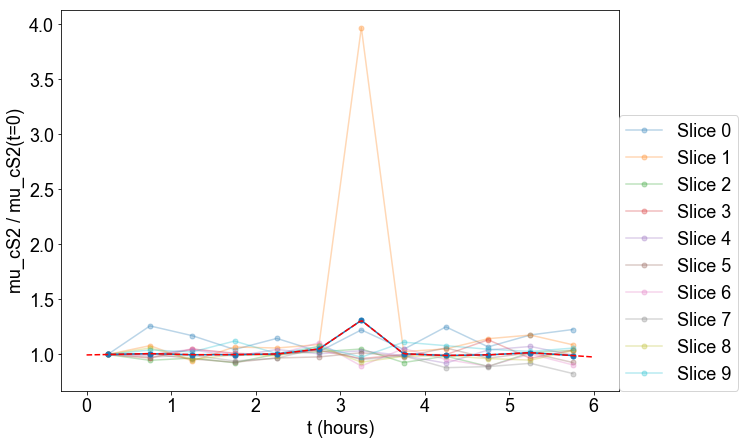

In [51]:
for point_n in range(10):
    plt.plot(time_centers * 1/3600, ob[:, :, 1][:, point_n] / ob[:, :, 1][0, point_n], 
             marker='.', markersize= 10, label='Slice %d' % point_n, alpha=0.3)
plt.legend(loc=(1,0))
plt.xlabel('t (hours)')
plt.ylabel('mu_cS2 / mu_cS2(t=0)')


avg_scaling = np.average([ob[:, :, 1][:, point_n] / ob[:, :, 1][0, point_n] for point_n in np.arange(1, 10)], axis=0)
fcorr = scipy.interpolate.interp1d(time_centers, 1/avg_scaling,
                                   kind = 'linear', fill_value='extrapolate', bounds_error=False)
fplot = scipy.interpolate.interp1d(time_centers, avg_scaling,
                                   kind = 'linear', fill_value='extrapolate', bounds_error=False)

plt.plot(time_centers * 1/3600, avg_scaling,
         marker='.', markersize= 10, label='avg')


x_plot = np.linspace(0, 3600 * 6, 200)
plt.plot(x_plot / 3600, fplot(x_plot), color='red', ls='--')
plt.show()

In [52]:
# for point_n in range(10):
#     plt.plot(time_centers * 1/3600, ob[:, :, 2][:, point_n], marker='.', markersize= 10, label='Slice %d' % point_n)
# plt.legend(loc=(1,0))
# plt.xlabel('t (hours)')
# plt.ylabel('sigma')
# plt.show()

In [53]:
# for point_n in range(10):
#     plt.plot(time_centers * 1/3600, ob[:, :, 2][:, point_n] / ob[:, :, 2][0, point_n], 
#              marker='.', markersize= 10, label='Slice %d' % point_n)
# plt.legend(loc=(1,0))
# plt.xlabel('t (hours)')
# plt.ylabel('sig_cS2 / sig_cS2(t=0)')

# plt.plot(time_centers * 1/3600, avg_scaling,
#          marker='.', markersize= 10, label='avg', lw=2)
# plt.show()

In [54]:
bg.corr_s2_decrease(fcorr)

Already applied correction, will not do it again!


#### AmBe 1

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


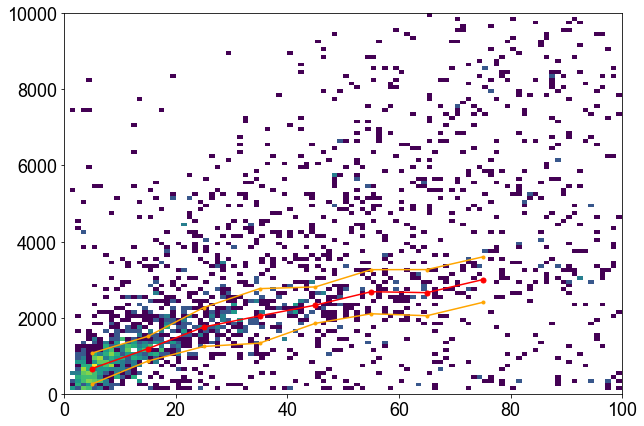

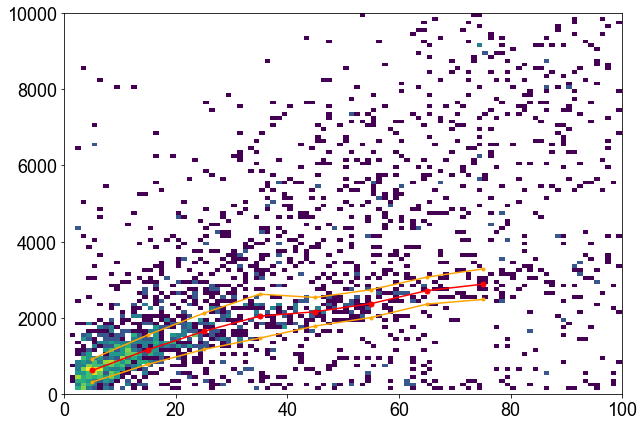

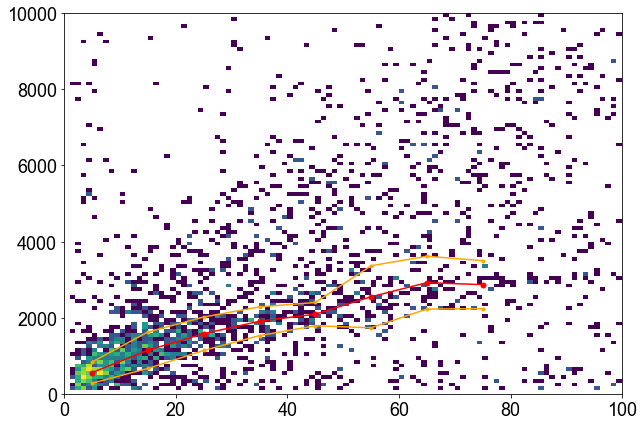

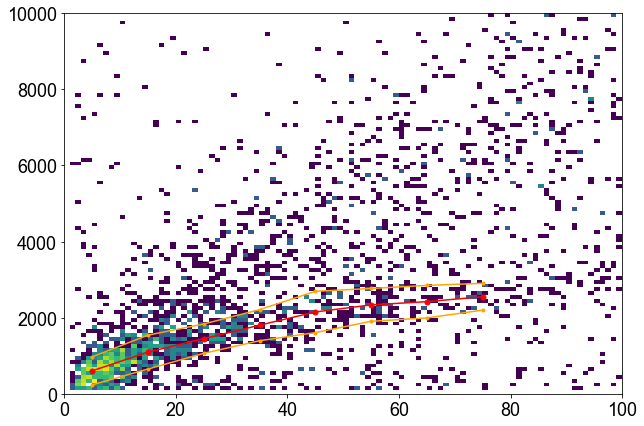

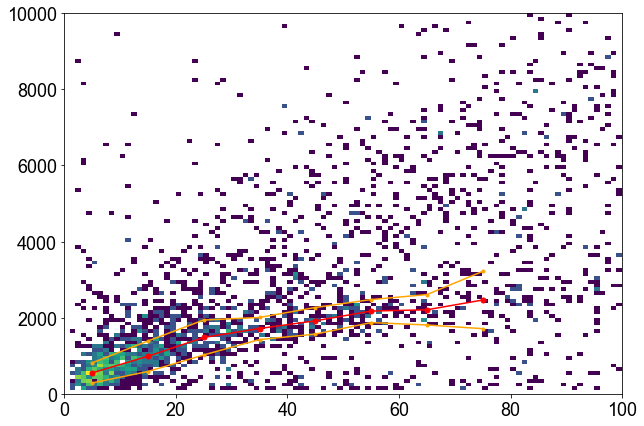

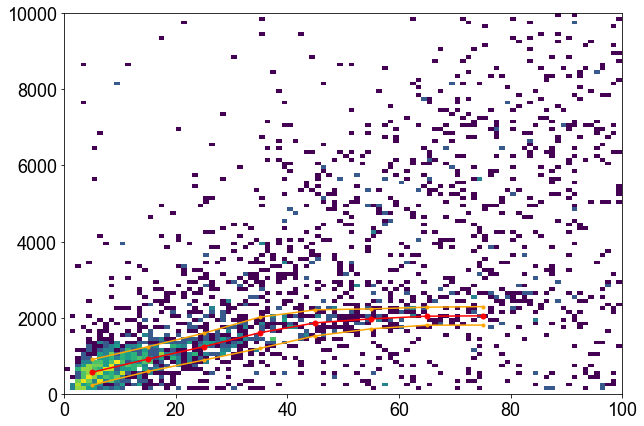

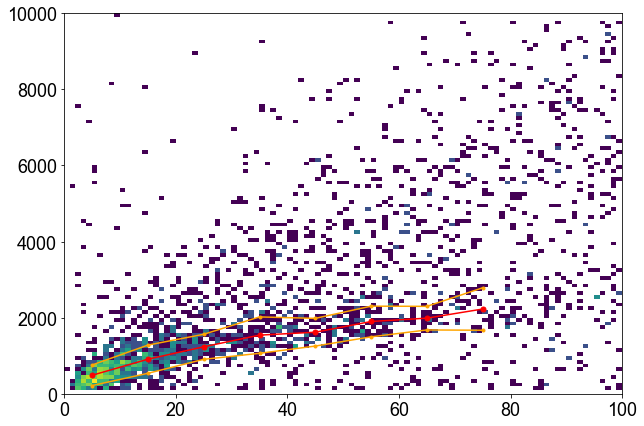

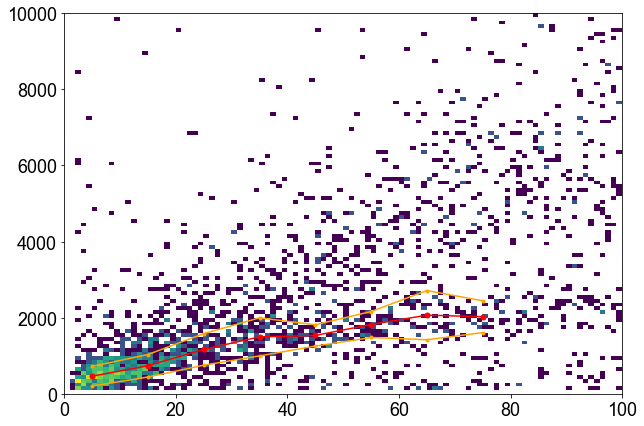

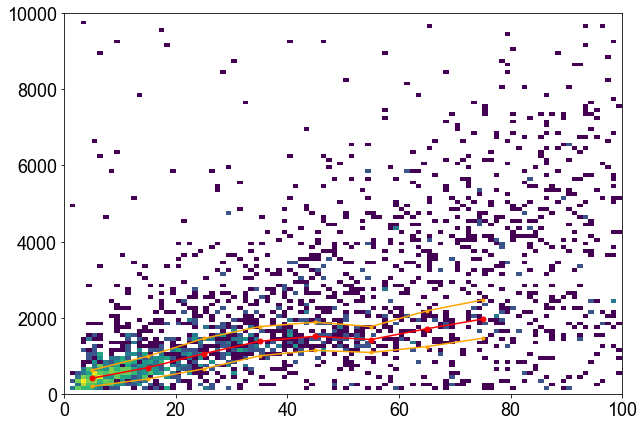

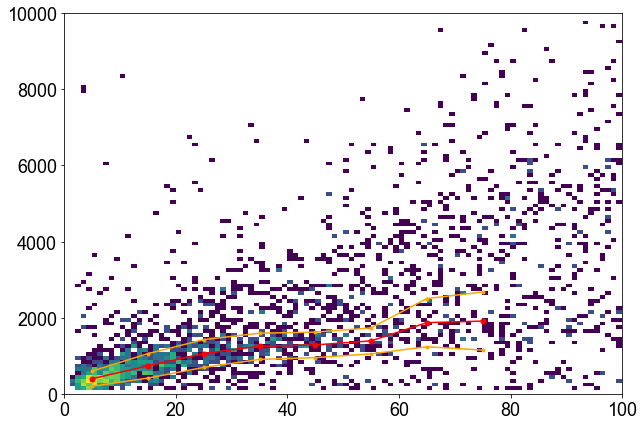

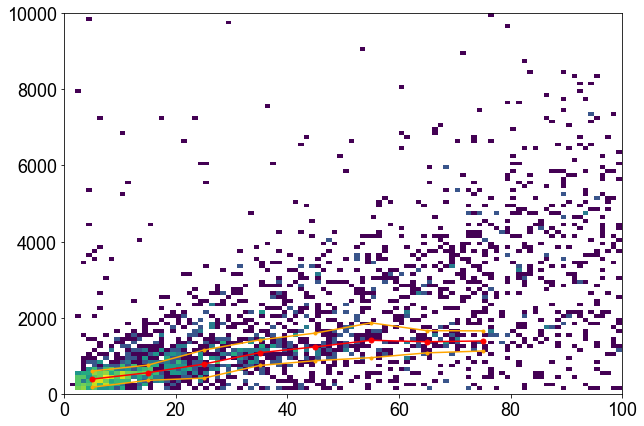

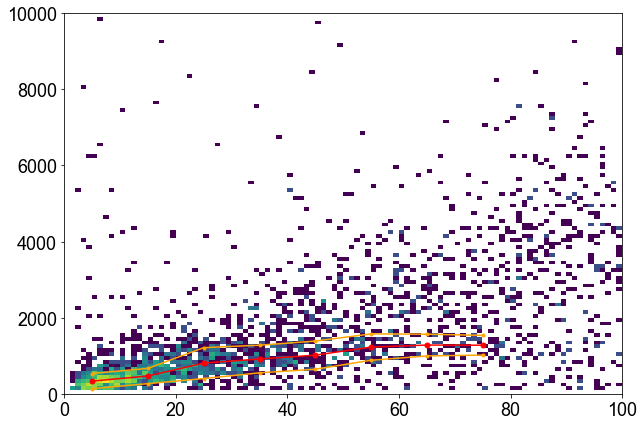

In [31]:
time_bands = []
time_bin_edges = np.linspace(0, 3600 * 6, 12 + 1)
time_centers = 0.5 * (time_bin_edges[:-1] + time_bin_edges[1:])
for time_start, time_stop in zip(time_bin_edges[:-1], time_bin_edges[1:]):
    time_range = (time_start, time_stop) # First hour
    time_slice = ambe_1.d[(ambe_1.d['t'] >= time_range[0]) & (ambe_1.d['t'] < time_range[1])]

    _band = fit_band(time_slice, 0, 80, 8, mode='progressive', mu_guess= 500, sigma_guess= 300, sigma_range=1.5,
                    limit_x0 = (100, 3e3))
    if plot_s2_corr:
        plot_raw_band(_band)
        plt.hist2d(time_slice['cs1'], time_slice['cs2'], range=((0, 100), (0, 10e3)), bins=100, norm=LogNorm())
        plt.show()
    time_bands.append(_band)


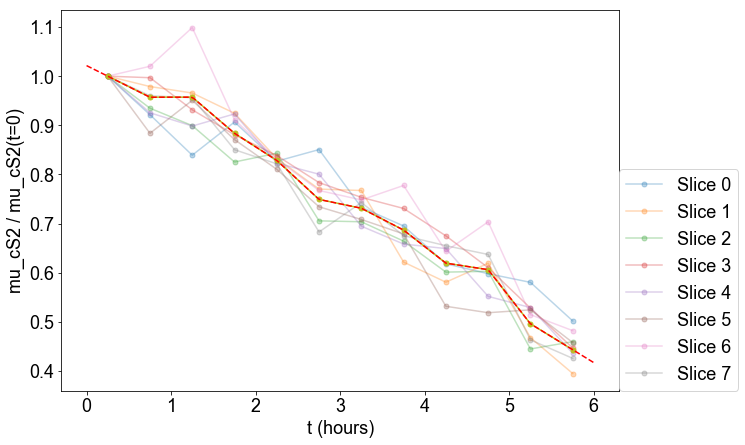

In [32]:
ob2 = np.array(time_bands)
for point_n in range(8):
    plt.plot(time_centers * 1/3600, ob2[:, :, 1][:, point_n] / ob2[:, :, 1][0, point_n], 
             marker='.', markersize= 10, label='Slice %d' % point_n, alpha=0.3)
plt.legend(loc=(1,0))
plt.xlabel('t (hours)')
plt.ylabel('mu_cS2 / mu_cS2(t=0)')


avg_scaling = np.average([ob2[:, :, 1][:, point_n] / ob2[:, :, 1][0, point_n] for point_n in np.arange(1, 8)], axis=0)
fcorr = scipy.interpolate.interp1d(time_centers, 1/avg_scaling,
                                   kind = 'linear', fill_value='extrapolate', bounds_error=False)
fplot = scipy.interpolate.interp1d(time_centers, avg_scaling,
                                   kind = 'linear', fill_value='extrapolate', bounds_error=False)

plt.plot(time_centers * 1/3600, avg_scaling,
         marker='.', markersize= 10, label='avg')


# x_plot = np.linspace(0, 3600 * 6, 200)
plt.plot(x_plot / 3600, fplot(x_plot), color='red', ls='--')



In [33]:
ambe_1.corr_s2_decrease(fcorr)

#### AmBe 2

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


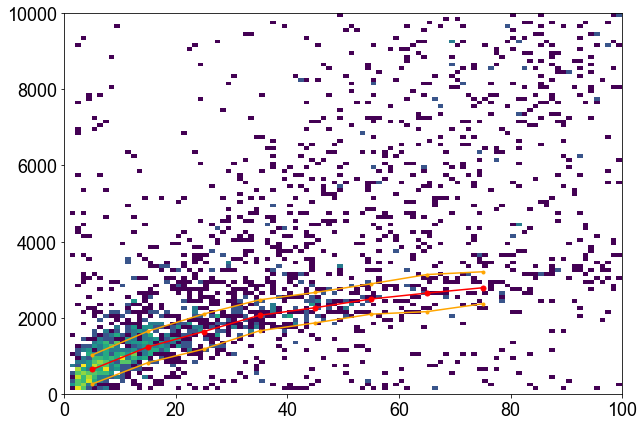

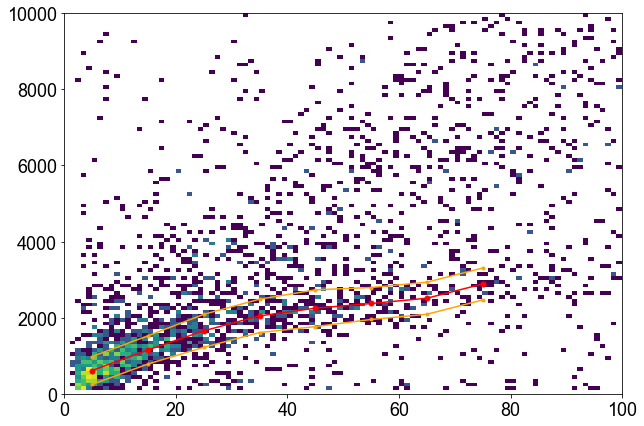

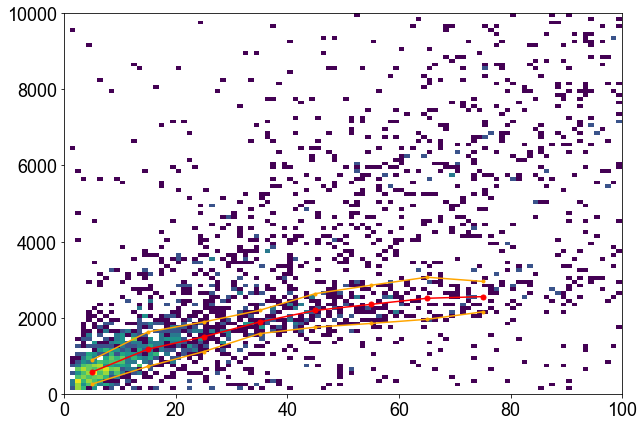

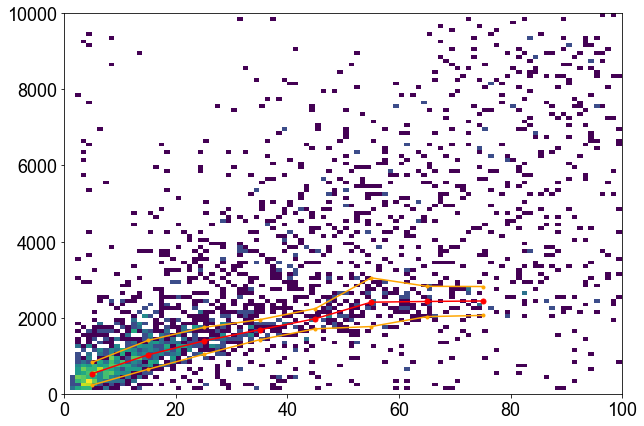

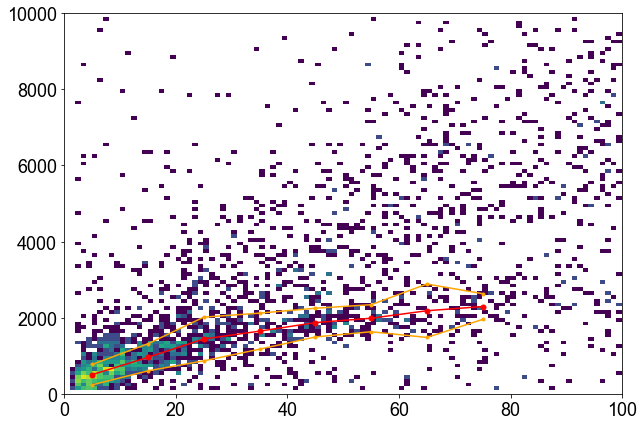

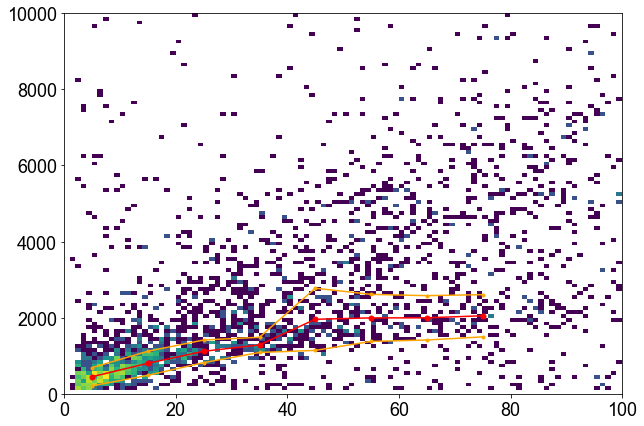

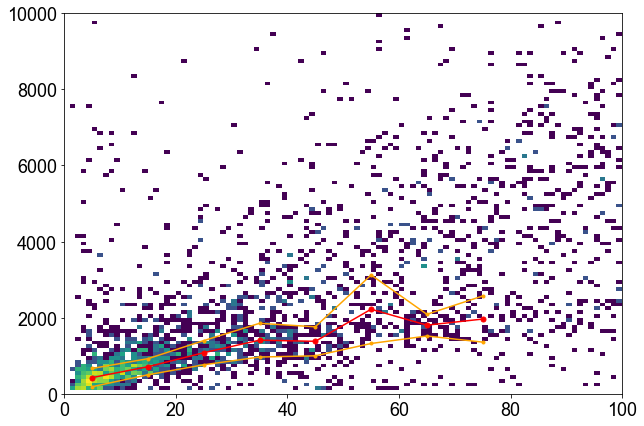

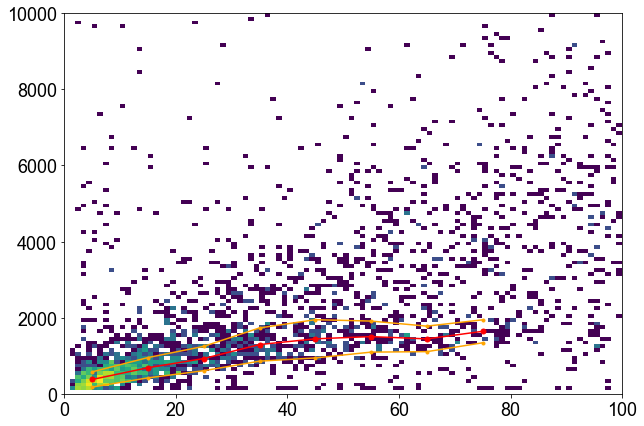

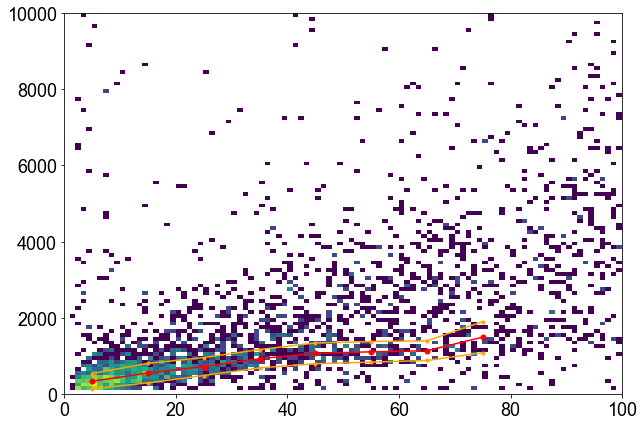

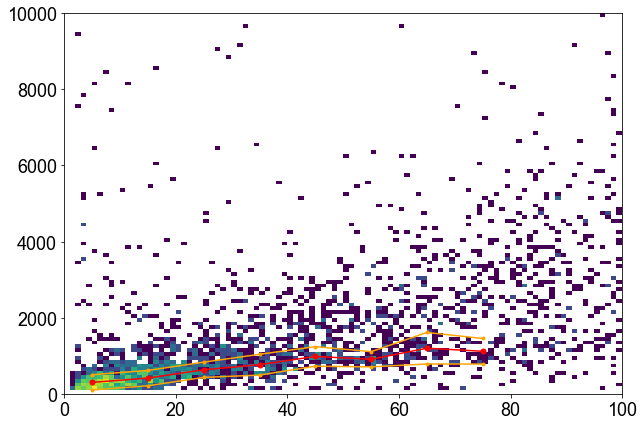

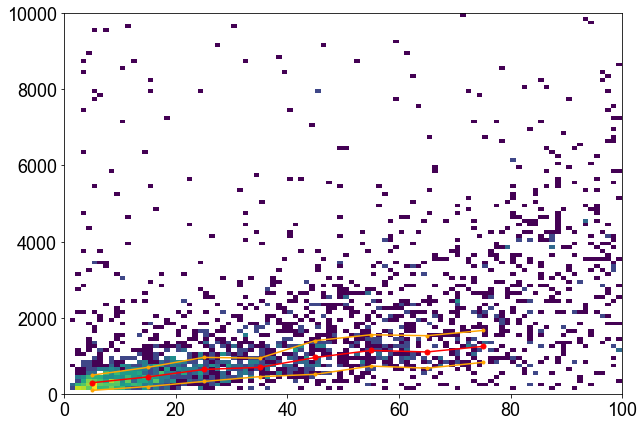

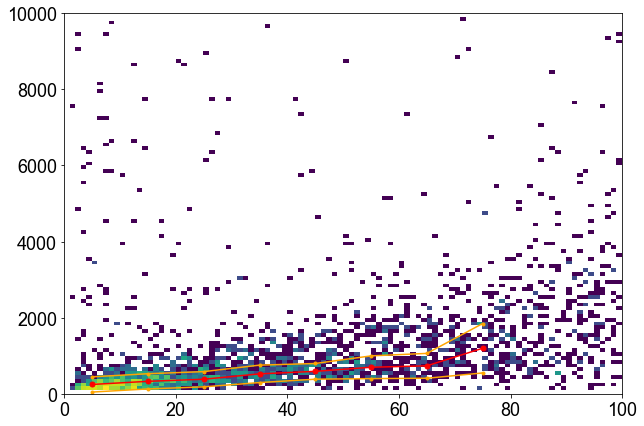

In [35]:
time_bands = []
time_bin_edges = np.linspace(0, 3600 * 6, 12 + 1)
time_centers = 0.5 * (time_bin_edges[:-1] + time_bin_edges[1:])
for time_start, time_stop in zip(time_bin_edges[:-1], time_bin_edges[1:]):
    time_range = (time_start, time_stop) # First hour
    time_slice = ambe_2.d[(ambe_2.d['t'] >= time_range[0]) & (ambe_2.d['t'] < time_range[1])]

    _band = fit_band(time_slice, 0, 80, 8, mode='progressive', mu_guess= 500, sigma_guess= 300, sigma_range=1.5,
                    limit_x0 = (100, 3e3))
    if plot_s2_corr:
        plot_raw_band(_band)
        plt.hist2d(time_slice['cs1'], time_slice['cs2'], range=((0, 100), (0, 10e3)), bins=100, norm=LogNorm())
        plt.show()
    time_bands.append(_band)

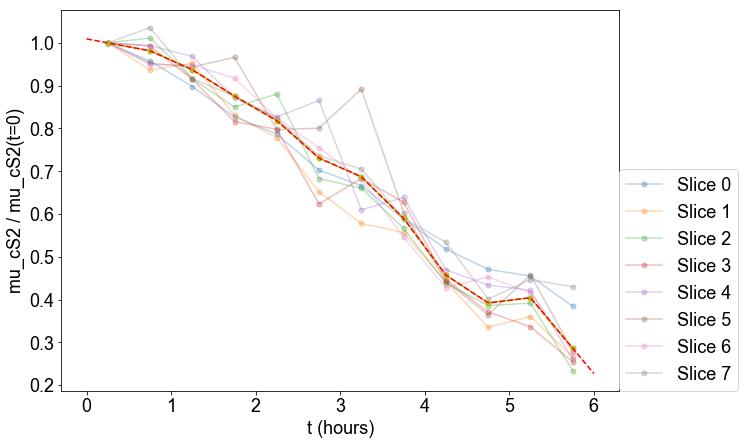

In [36]:
ob2 = np.array(time_bands)
for point_n in range(8):
    plt.plot(time_centers * 1/3600, ob2[:, :, 1][:, point_n] / ob2[:, :, 1][0, point_n], 
             marker='.', markersize= 10, label='Slice %d' % point_n, alpha=0.3)
plt.legend(loc=(1,0))
plt.xlabel('t (hours)')
plt.ylabel('mu_cS2 / mu_cS2(t=0)')


avg_scaling = np.average([ob2[:, :, 1][:, point_n] / ob2[:, :, 1][0, point_n] for point_n in np.arange(1, 8)], axis=0)
fcorr = scipy.interpolate.interp1d(time_centers, 1/avg_scaling,
                                   kind = 'linear', fill_value='extrapolate', bounds_error=False)
fplot = scipy.interpolate.interp1d(time_centers, avg_scaling,
                                   kind = 'linear', fill_value='extrapolate', bounds_error=False)

plt.plot(time_centers * 1/3600, avg_scaling,
         marker='.', markersize= 10, label='avg')


# x_plot = np.linspace(0, 3600 * 6, 200)
plt.plot(x_plot / 3600, fplot(x_plot), color='red', ls='--')

In [37]:
ambe_2.corr_s2_decrease(fcorr)

### Combine datasets

In [56]:
# Combine data for same sources
na = combine_frameworks(na_0, na_1)
ambe = combine_frameworks(ambe_1, ambe_2)
nr = ambe
er = combine_frameworks([bg, cs, na])

### S2 width

To do: take another critical look at all this!

In [17]:
df_list = [ambe_1, ambe_2, bg, cs, na_0, na_1]

# High width
for df in df_list:
    df.cut_s2_range_50p_area(dt_range = (5, 57), apply=True, plot=False)

# Low width
for df in df_list:
    df.cut_s2_range_50p_area_low(-50, apply=True)

Diffusion is 15.62 +- 0.24 +- 0.41 cm**2 / s
Diffusion is 15.62 +- 0.48 cm**2 / s
Cutoff at 251.5 ns
s2_width_difference below 251.5 selection: 1933 rows removed (98.42% passed)
Diffusion is 15.47 +- 0.29 +- 0.41 cm**2 / s
Diffusion is 15.47 +- 0.50 cm**2 / s
Cutoff at 251.5 ns
s2_width_difference below 251.5 selection: 2150 rows removed (98.29% passed)
Diffusion is 15.64 +- 0.42 +- 0.41 cm**2 / s
Diffusion is 15.64 +- 0.59 cm**2 / s
Cutoff at 251.5 ns
s2_width_difference below 251.5 selection: 1039 rows removed (98.79% passed)
Diffusion is 17.92 +- 0.62 +- 0.41 cm**2 / s
Diffusion is 17.92 +- 0.75 cm**2 / s
Cutoff at 251.5 ns
s2_width_difference below 251.5 selection: 123 rows removed (99.26% passed)
Diffusion is 15.16 +- 1.35 +- 0.41 cm**2 / s
Diffusion is 15.16 +- 1.41 cm**2 / s
Cutoff at 251.5 ns
s2_width_difference below 251.5 selection: 65 rows removed (99.39% passed)
Diffusion is 17.78 +- 1.10 +- 0.41 cm**2 / s
Diffusion is 17.78 +- 1.18 cm**2 / s
Cutoff at 251.5 ns
s2_width_dif

### Add waveforms

In [19]:
# Add waveforms... This step may take a while (especially if cache files need to be built)
# ambe.add_s1_waveforms()
# bg.add_s1_waveforms()
# cs.add_s1_waveforms()
# na.add_s1_waveforms()

### NR/ER selection

In [69]:
# Function definitions
def nr_low(s1):
    # Piecewise def
    return np.array([300*np.sqrt(_s1 - 10) + 0  if _s1>10 else 100 for _s1 in s1])

def nr_high(s1):
    return 350*np.sqrt(s1 - 0) + 1000

# Function definitions
def er_low(s1):
    return 60 * s1 + 0

def er_high(s1):
    return 100 * s1 + 3e3

In [92]:
def cut_band_old(x, band_type):
    if band_type == 'nr':
        low_function = nr_low
        high_function = nr_high
    elif band_type == 'er':
        low_function = er_low
        high_function = er_high
    else:
        raise ValueError('What band do YOU want? You gave this: %s' % band_type)
    
    xnew = deepcopy(x)
    
    xnew.d = cuts.selection(xnew.d, xnew.d['cs2'] < high_function(xnew.d['cs1']), '%s band upper limit' % band_type)
    xnew.d = cuts.selection(xnew.d, xnew.d['cs2'] > low_function(xnew.d['cs1']), '%s band lower limit' % band_type)
    
    return xnew

In [93]:
def plot_band(band_type, x_plot = np.linspace(0, 400, 401), **kwargs):
    if band_type == 'nr':
        low_function = nr_low
        high_function = nr_high
    elif band_type == 'er':
        low_function = er_low
        high_function = er_high
    else:
        raise ValueError('What band do YOU want? You gave this: %s' % band_type)
        
    for f in (low_function, high_function):
        plt.plot(x_plot, f(x_plot), **kwargs)
    return

In [94]:
nr_nrsel = cut_band_old(nr, 'nr')
nr_ersel = cut_band_old(nr, 'er')
er_ersel = cut_band_old(er, 'er')
bg_nrsel = cut_band_old(bg, 'nr')

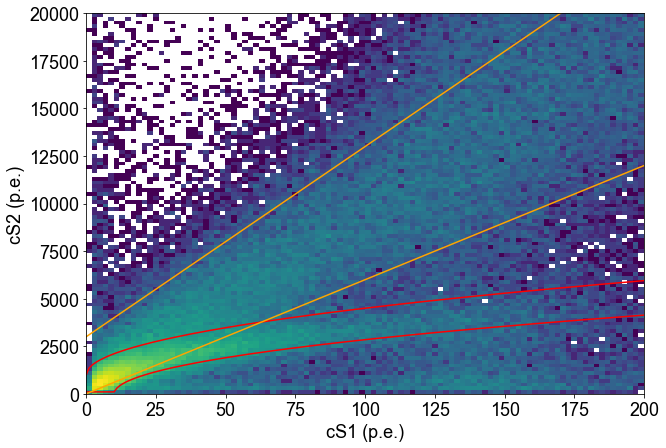

In [95]:
nr.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 200), (0, 20e3)))
plot_band('nr', color='red')
plot_band('er', color='orange')
plt.show()

### Proper band selection

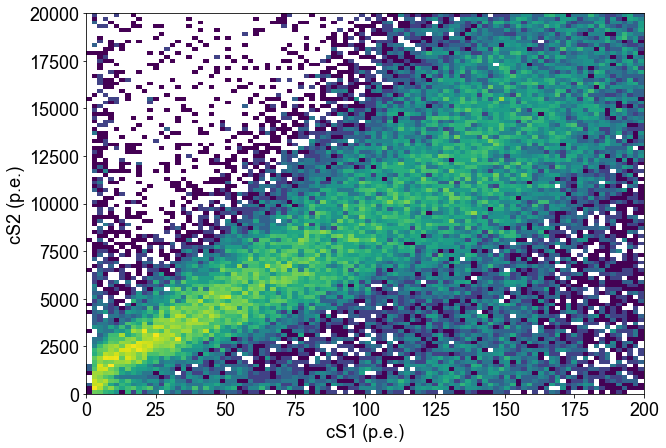

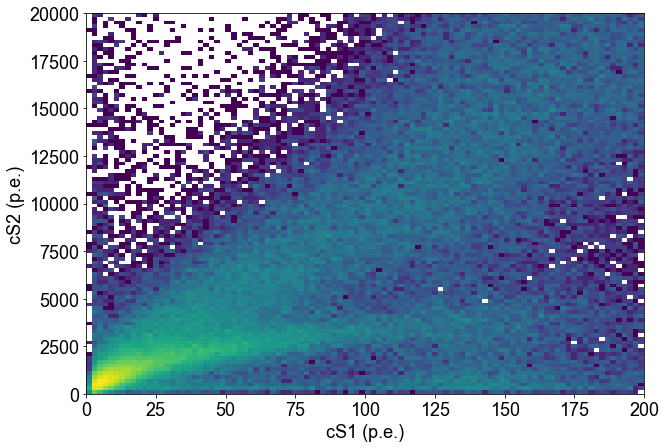

In [74]:
er.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 200), (0, 20e3)))
plt.show()
ambe.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 200), (0, 20e3)))
plt.show()

In [75]:
er_band = fit_band(er.d, 0, 200, 20, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3)
er_band_na = fit_band(na.d, 0, 200, 20, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3)
er_band_cs = fit_band(cs.d, 0, 200, 20, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3)
er_band_bg = fit_band(bg.d, 0, 200, 20, 'progressive', 1.5, mu_guess = 2e3, sigma_guess = 1e3)
nr_band = fit_band(nr.d, 0, 200, 20, 'progressive', 1., mu_guess = 2e3, sigma_guess = 1e3,
                  limit_x0 = (0, 4e3), limit_x1 = (200, 1e3))

nr_band_p = process_band(nr_band)
er_band_p = process_band(er_band)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


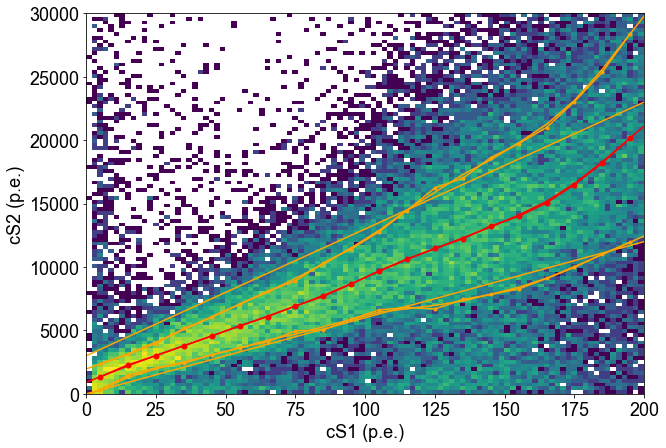

In [79]:
# plot_raw_band(er_band_na)
# plot_raw_band(er_band_cs)
# plot_raw_band(er_band_bg)
plot_raw_band(er_band)
plot_processed_band(er_band_p)
plot_band('er', color='orange')
er.plot_cs1cs2(bins = 100, norm=LogNorm(), range=((0, 200), (0, 30e3)))



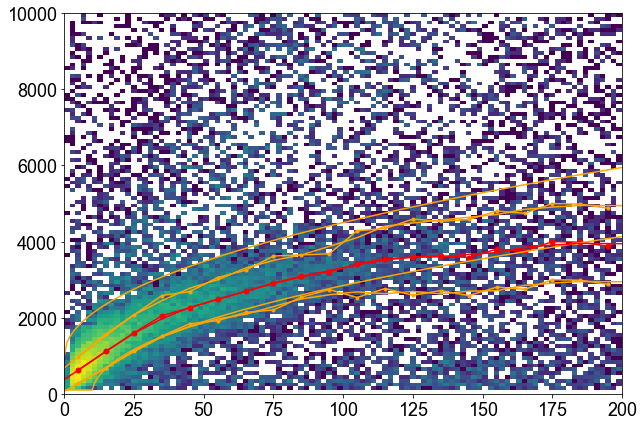

In [80]:
plot_dfs_diffs(nr, bg, range=((0, 200), (0, 10e3)), norm=LogNorm(), bins=100)
plot_raw_band(nr_band)
plot_band('nr', color='orange')
plot_processed_band(nr_band_p)

### Apply selection

Note to self. This may be better put in the XAMSAnalysis framework... (Including the spectrum!)

In [101]:
def cut_band(x, band):
    ''' 
    Cut on events that should be in band. Requires band input: (low, middle, high) interpolating functions.
    '''
    xnew = deepcopy(x)
    xnew.d = cuts.selection(xnew.d, xnew.d['cs2'] < band[2](xnew.d['cs1']), 'Band upper limit')
    xnew.d = cuts.selection(xnew.d, xnew.d['cs2'] > band[0](xnew.d['cs1']), 'Band lower limit')
    return xnew    

In [106]:
nr_nrsel = cut_band(nr, nr_band_p)
nr_ersel = cut_band(nr, er_band_p)
er_ersel = cut_band(er, er_band_p)
bg_nrsel = cut_band(bg, nr_band_p)

### Inspect cS1 spectrum

In [107]:
print('Pending, check new function!')

Pending, check new function!


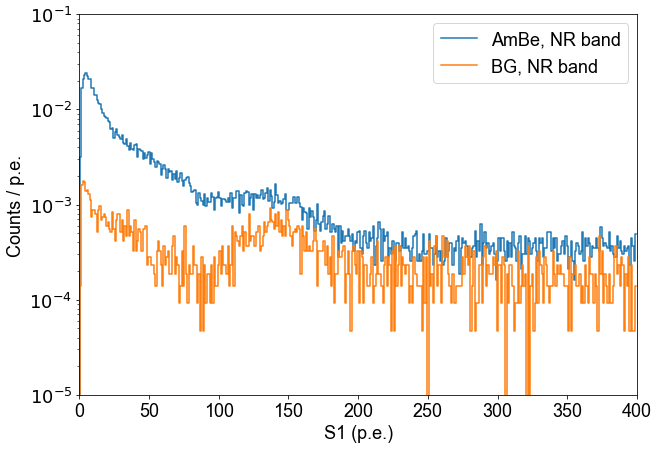

In [113]:
# plt.hist(nr_nrsel.d['cs1'], histtype='step', bins=200, label='NR')
nr_nrsel.plot_cs1_rate(label='AmBe, NR band')
bg_nrsel.plot_cs1_rate(label='BG, NR band')

# plt.hist(d_er['cs1'], histtype='step', bins=200, label='ER')
plt.xlabel('S1 (p.e.)')
plt.ylabel('Counts / p.e.')
plt.legend()
plt.ylim(1e-5, 1e-1)
plt.yscale('log')
plt.xlim(0, 400)
plt.show()

### Pulses

#### Functions

In [109]:
def integrate_until_fraction(w, area_tot, fractions_desired, results):
    """For array of fractions_desired, integrate w until fraction of area is reached, place sample index in results
    Will add last sample needed fractionally.
    eg. if you want 25% and a sample takes you from 20% to 30%, 0.5 will be added.
    Assumes fractions_desired is sorted and all in [0, 1]!
    This function is stolen and modified from Pax - Erik Hogenbirk September 2017
    """
    fraction_seen = 0
    current_fraction_index = 0
    needed_fraction = fractions_desired[current_fraction_index]
    for i, x in enumerate(w):
        # How much of the area is in this sample?
        fraction_this_sample = x/area_tot
        # Will this take us over the fraction we seek?
        # Must be while, not if, since we can pass several fractions_desired in one sample
        while fraction_seen + fraction_this_sample >= needed_fraction:
            # Yes, so we need to add the next sample fractionally
            area_needed = area_tot * (needed_fraction - fraction_seen)
            if x != 0:
                results[current_fraction_index] = i + area_needed/x
            else:
                results[current_fraction_index] = i
            # Advance to the next fraction
            current_fraction_index += 1
            if current_fraction_index > len(fractions_desired) - 1:
                return
            needed_fraction = fractions_desired[current_fraction_index]
        # Add this sample's area to the area seen, advance to the next sample
        fraction_seen += fraction_this_sample
    if needed_fraction == 1:
        results[current_fraction_index] = len(w)
    else:
        return -1

In [110]:
def add_percentiles(d, fractions_desired = [0.1, 0.2, 0.3, 0.4]):
    '''
    Compute the point in the S1 waveform where 10, 20, 30 and 40 percent of the area is reached.
    Adds properties to the dataframe: `s1_X0p_point` and `s1_fraction_outside_pulse`.
    Time in ns since start of pulse (pulse[0] = 0 ns)
    '''
    s1_percentile_points = []
    s1_area_fraction_outside_pulse = []
    
    for i, ev in d.iterrows():
        pulse = np.array(ev['s1_pulse'])
        area_times = np.ones(4) * float('nan')
        area_tot = ev['s1']
        return_status = integrate_until_fraction(
            pulse, area_tot, fractions_desired=fractions_desired, results=area_times)
        if return_status == -1:
            print('Warning: fraction not reached in event %d of run %d' % (ev['event_number'], 
                                                                          ev['run_number']))
        s1_percentile_points.append(2. * area_times) # Correct for 2 ns here
        s1_area_fraction_outside_pulse.append(1 - np.sum(pulse) / ev['s1'])
        
    s1_percentile_points = np.array(s1_percentile_points)
    for i, fraction in enumerate(fractions_desired):
        d['s1_%d_percentile_point' % (fraction * 100)] = s1_percentile_points[:, i]        
    d['s1_fraction_outside_pulse'] = s1_area_fraction_outside_pulse
    return 
        

def build_pulse_hist_entries(d, alignment_field):
    '''
    Align the S1 pulses. This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    The function returns two arrays, one containing the time points (shifted by the alignment field) and 
    one containing the weight, so that lower-than 1 bin sampling and alignment is possible.
    '''
    time_edges = np.linspace(-100, 300, 201)
    # Arbitrarily put the first sample EXACTLY at zero rather than at bin edges
    time = time_edges[:-1]
    time_entries = []
    weight_entries = []
    
    for i, ev in d.iterrows():
        time_entries.append(time + 100 - ev[alignment_field])
        weight_entries.append(np.array(ev['s1_pulse']) / ev['s1'])
    
    return np.concatenate(time_entries), np.concatenate(weight_entries)

def compute_average_pulse(d, alignment_field, dt = 2):
    '''
    Compute the average pulse, calling the underlying `build_pulse_hist_entries` routine. 
    This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    dt is sample time in ns, which may be lower than the raw sample of 2 ns. Go ahead and try!
    '''
    n_bins_time = np.floor(400 / dt) + 1
    if 400 % dt:
        print('Warning: please use a divisor of 400 for your time bins (i.e. 1, 0.2, 200, ...) .')
    time_edges = np.linspace(-100, 300, n_bins_time)
    times, weights = build_pulse_hist_entries(d, alignment_field)
    
    # This takes only the left bin edges, so that the first sample is zero.
    time = time_edges[:-1]
    amplitude, _ = np.histogram(times, bins=time_edges, weights=weights)
    # Normalization
    amplitude = amplitude / len(d) / dt
    
    return time, amplitude

def plot_average_pulse_in_slice(d, alignment_field, dt = 2, cs1_range=(0, np.inf), **kwargs):
    sel = (d['cs1'] >= cs1_range[0]) & (d['cs1'] < cs1_range[1])
    time, average_pulse = compute_average_pulse(d[sel], alignment_field, dt)
    plt.plot(time, average_pulse, **kwargs)
    plt.xlabel('Time (ns)')
    plt.ylabel('Average pulse ((%d ns)$^{-1}$)' % dt)
    return 

#### Compare!

This should be done in the XAMSAnalysis object now. 

In [111]:
# This adds the percentiles based on the pulse waveform...
for x in [nr_nrsel, nr_ersel, er_ersel, bg_nrsel]:
    add_percentiles(x.d)

KeyError: 's1_pulse'

In [117]:
def add_percentiles_from_pax(d, fractions_desired = [0.1, 0.2, 0.3, 0.4]):
    '''
    Compute the position in ns in the waveform where a certain fraction of the area is reached. Should give the same as 
    add_percentiles!
    '''
    for frac in fractions_desired:
        pct = frac * 100
        shift_from_midpoint = d['s1_time_from_midpoint_%dp' % pct]
        shift_error = d['s1_center_time'] - round(d['s1_center_time'] / 2) * 2
        shift_from_center_to_midpoint = d['s1_area_midpoint'] - d['s1_center_time']
        d['s1_%d_percentile_point_pax' % pct] = 100 + shift_from_center_to_midpoint + shift_from_midpoint + shift_error
    return


In [120]:
for x in [nr_nrsel, nr_ersel, er_ersel, bg_nrsel]:
    add_percentiles_from_pax(x.d)

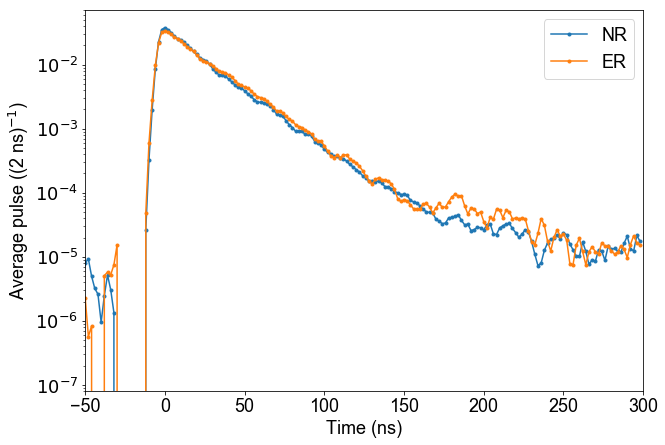

In [150]:
plot_average_pulse_in_slice(nr_nrsel.d, 's1_10_percentile_point_pax', dt=2, cs1_range=(30, 40), label='NR', marker='.')
plot_average_pulse_in_slice(er_ersel.d, 's1_10_percentile_point_pax', dt=2, cs1_range=(30, 40), label='ER', marker='.')
plt.xlim(-50, 300)
plt.legend()
plt.yscale('log')
plt.show()

### Dump objects to file

In [151]:
pickle.dump((nr_nrsel.d, er_ersel.d, bg_nrsel.d), open('highfield_dataframes.pickle', 'wb'))

## Open questions

  * Why does the distribution in cS1/cS2 look so different for Na22?
  * What is that population with low width?
  * Is the difference in S2 width due to a different liquid level?
  * As the ER band rate is the same at high cS1 in AmBe/BG, why is the rate below the band higher? 
  * What is the equivalent energy in the cS1/cS2 plot? How for does the NR spectrum go?
  * What is that crap below the ER band at 150 p.e. cS1?

## Checks and secondary effects

### The Weird Population

After some careful consideration and discussion with Sander, consider the following...

There are more events below the bands than above it, suggesting that we lose S2 but not S1 (electrons lost but not photons). If the events below the band are selected, you can see that the events seem to be good, legitimate events:
- The S2 AFT is in bounds (suggesting it's a true S2)
- The S1 AFT is in agreement with the z-position (the S1-S2 pair is correct, also, probably no gamma-X)
- No time dependance

Where do we see weird things? Well, the following:
- The **S2 width is low**. This effect is isolated in the following graph.
- There is a mild bias in z.

What could it be? Most likely explanation: it is events at the edges. This would explain why we do not see it in high energy sources (Na): the low energy scatters coming from BG are probably largely due to low-energy gammas with a very low stopping power. These'll be stopped at the edges. If it is at the edges, the path through the the gas might be shorter due to the capillary effect. 

That said... It's also in the Cs data. But wait, is it also in the Na data? It could still be background...



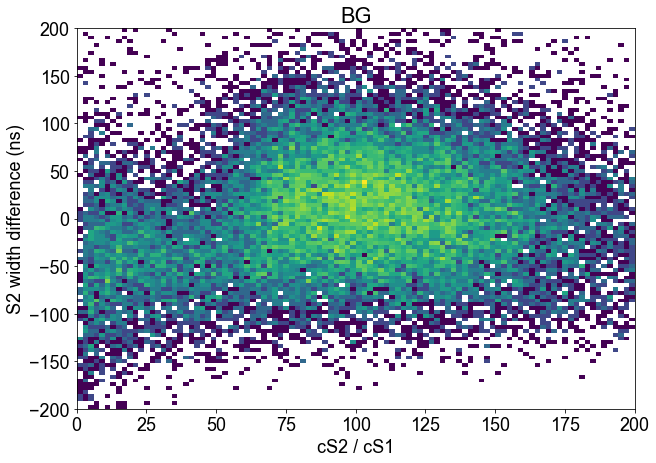

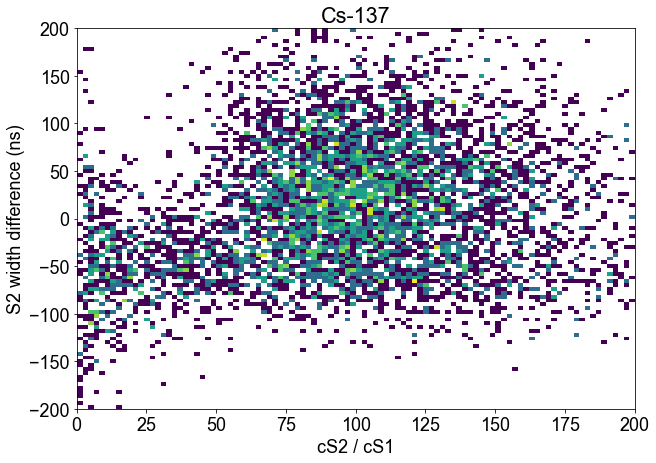

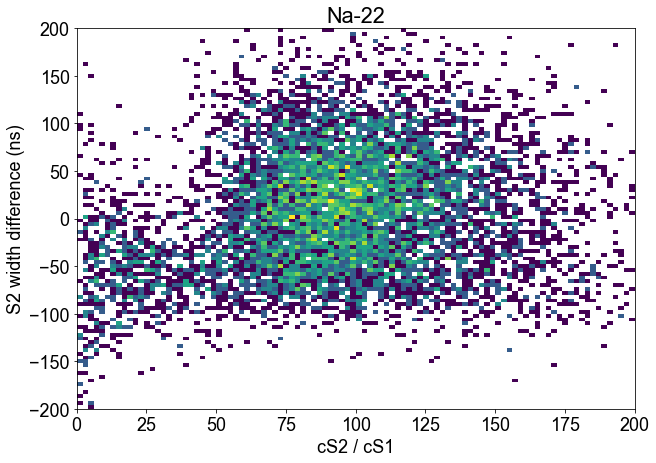

In [17]:
plt.hist2d(bg.d['cs2'] / bg.d['cs1'], bg.d['s2_width_difference'], bins=100, norm=LogNorm(),
          range=((0, 200), (-200, 200)))
plt.xlabel('cS2 / cS1')
plt.ylabel('S2 width difference (ns)')
plt.title('BG')
plt.savefig('figs/s2_width_v_ratio.png', bbox_inches='tight')
plt.show()

plt.hist2d(cs.d['cs2'] / cs.d['cs1'], cs.d['s2_width_difference'], bins=100, norm=LogNorm(),
          range=((0, 200), (-200, 200)))
plt.xlabel('cS2 / cS1')
plt.ylabel('S2 width difference (ns)')
plt.title('Cs-137')
plt.show()

plt.hist2d(na.d['cs2'] / na.d['cs1'], na.d['s2_width_difference'], bins=100, norm=LogNorm(),
          range=((0, 200), (-200, 200)))
plt.xlabel('cS2 / cS1')
plt.ylabel('S2 width difference (ns)')
plt.title('Na-22')
plt.show()

### Weird population...

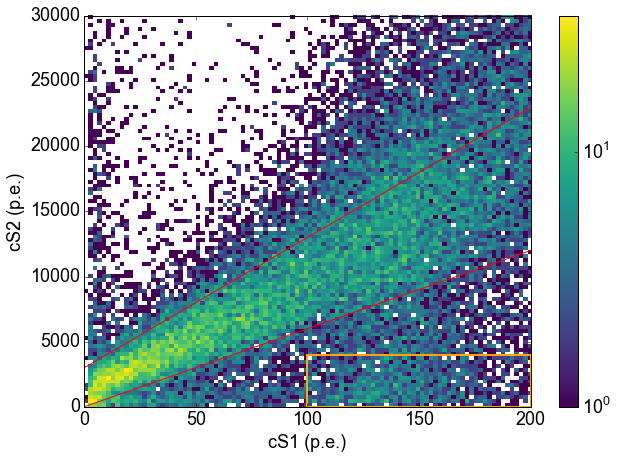

In [42]:
plt.plot(x_plot, er_high(x_plot), color='red')
plt.plot(x_plot, er_low(x_plot),  color='red')
bg.plot_cs1cs2(bins=100, range=((0, 200), (0, 30e3)), norm=LogNorm())
plt.colorbar()
draw_box((100, 200), (0, 4000), edgecolor='orange', lw=2)
plt.show()

In [43]:
len(bg.d) / (6 * 3600) #/ (0.2 * 0.085) 

1.3762962962962964

In [44]:
1 / (0.2 * 0.085) 

58.8235294117647

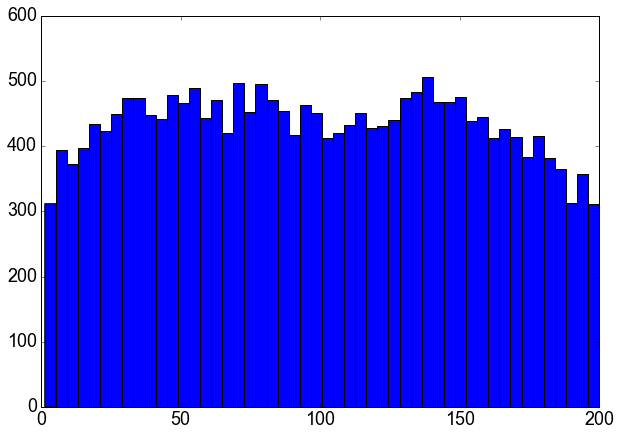

In [45]:
plt.hist(d_er['cs1'], bins=50)
plt.show()

In [46]:
good = d_er
good_low_s2 = cuts.range_selection(d_er, 'cs2', (0, 4000))
good_low_s1 = cuts.range_selection(d_er, 'cs1', (100, 200))

bad = cuts.range_selection(bg.d, 'cs1', (100, 200))
bad = cuts.range_selection(bad, 'cs2', (0, 4000))

cs2 in [0, 4000) selection: 18138 rows removed (16.25% passed)
cs1 in [100, 200) selection: 11034 rows removed (49.05% passed)
cs1 in [100, 200) selection: 12770 rows removed (57.04% passed)
cs2 in [0, 4000) selection: 14995 rows removed (11.58% passed)


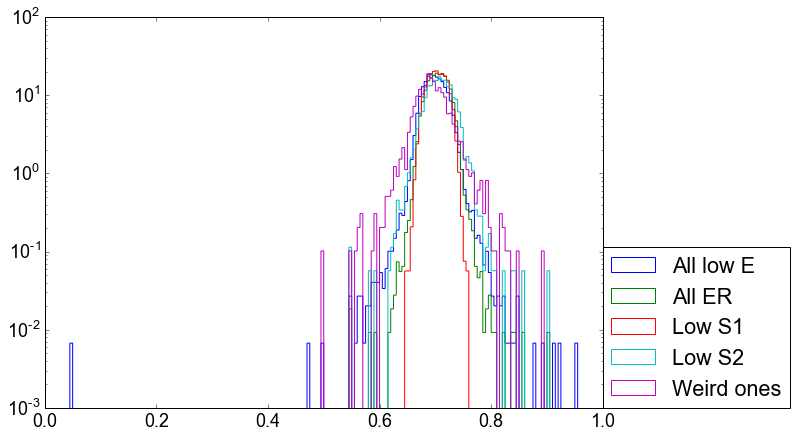

In [47]:
plt.hist(bg.d['s2_area_fraction_top'], bins=200, histtype='step', label='All low E', normed=True, range=(0,1))
plt.hist(good['s2_area_fraction_top'], bins=200, histtype='step', label='All ER', normed=True, range=(0,1))
plt.hist(good_low_s1['s2_area_fraction_top'], bins=200, histtype='step', label='Low S1', normed=True, range=(0,1))
plt.hist(good_low_s2['s2_area_fraction_top'], bins=200, histtype='step', label='Low S2', normed=True, range=(0,1))
plt.hist(bad['s2_area_fraction_top'], bins=200, histtype='step', label='Weird ones', normed=True, range=(0,1))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [48]:
plt.hist(bg.d['s1_aft_difference'], bins=200, histtype='step', label='All low E', normed=True, range=(0,1))
plt.hist(good['s1_aft_difference'], bins=200, histtype='step', label='All ER', normed=True, range=(0,1))
plt.hist(good_low_s1['s1_aft_difference'], bins=200, histtype='step', label='Low S1', normed=True, range=(0,1))
plt.hist(good_low_s2['s1_aft_difference'], bins=200, histtype='step', label='Low S2', normed=True, range=(0,1))
plt.hist(bad['s1_aft_difference'], bins=200, histtype='step', label='Weird ones', normed=True, range=(0,1))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

KeyError: 's1_aft_difference'

In [ ]:
plt.hist(bg.d['t'], bins=200, histtype='step', label='All low E', normed=True, range=(0,6*3600))
plt.hist(good['t'], bins=200, histtype='step', label='All ER', normed=True, range=(0,6*3600))
plt.hist(good_low_s1['t'], bins=200, histtype='step', label='Low S1', normed=True, range=(0,6*3600))
plt.hist(good_low_s2['t'], bins=200, histtype='step', label='Low S2', normed=True, range=(0,6*3600))
plt.hist(bad['t'], bins=200, histtype='step', label='Weird ones', normed=True, range=(0,6*3600))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
plt.hist(bg.d['z'], bins=200, histtype='step', label='All low E', normed=True, range=(-10,0))
plt.hist(good['z'], bins=200, histtype='step', label='All ER', normed=True, range=(-10,0))
plt.hist(good_low_s1['z'], bins=200, histtype='step', label='Low S1', normed=True, range=(-10,0))
plt.hist(good_low_s2['z'], bins=200, histtype='step', label='Low S2', normed=True, range=(-10,0))
plt.hist(bad['z'], bins=200, histtype='step', label='Weird ones', normed=True, range=(-10,0))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
plt.scatter(good['drift_time'], good['s2_range_50p_area'], edgecolor='None', color='red', s=5)
plt.scatter(bad['drift_time'], bad['s2_range_50p_area'], edgecolor='None')
plt.axhline(100)

In [ ]:
ran = (-500, 500)

plt.hist(bg.d['s2_width_difference'], bins=200, histtype='step', label='All low E', normed=True, range=ran)
plt.hist(good['s2_width_difference'], bins=200, histtype='step', label='All ER', normed=True, range=ran)
plt.hist(good_low_s1['s2_width_difference'], bins=200, histtype='step', label='Low S1', normed=True, range=ran)
plt.hist(good_low_s2['s2_width_difference'], bins=200, histtype='step', label='Low S2', normed=True, range=ran)
plt.hist(bad['s2_width_difference'], bins=200, histtype='step', label='Weird ones', normed=True, range=ran)
# plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
bg.cut_s1_aft(plot=True, apply=False)

In [ ]:
bla = bg.d

In [ ]:
# Error from near the edges where interpolation fails
bla = cuts.isfinite(bla, 's1_aft_difference')

In [ ]:
plt.set_cmap('jet')
plt.scatter(bla['cs1'], bla['cs2'], c=np.abs(bla['s1_aft_difference']), vmax= 0.1,
            edgecolor='None', marker='.', s=10)
plt.colorbar()
plt.xlim(0, 200)
plt.ylim(0, 30e3)

### Weird population NR

In [ ]:
ambe_1.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 200), (0, 30000)))
plt.plot(x_plot, nr_low(x_plot))
plt.plot(x_plot, nr_high(x_plot))
draw_box((100, 200), (0, 2500), edgecolor='orange')

In [ ]:
good = d_nr
good_low_s2 = cuts.range_selection(d_nr, 'cs2', (0, 2500))
good_low_s1 = cuts.range_selection(d_er, 'cs1', (100, 200))

bad = cuts.range_selection(ambe_1.d, 'cs1', (100, 200))
bad = cuts.range_selection(bad, 'cs2', (0, 2500))

In [ ]:
ran = (-500, 500)

plt.hist(bg.d['s2_width_difference'], bins=200, histtype='step', label='All low E', normed=True, range=ran)
plt.hist(good['s2_width_difference'], bins=200, histtype='step', label='All NRa', normed=True, range=ran)
plt.hist(good_low_s1['s2_width_difference'], bins=200, histtype='step', label='Low S1', normed=True, range=ran)
plt.hist(good_low_s2['s2_width_difference'], bins=200, histtype='step', label='Low S2', normed=True, range=ran)
plt.hist(bad['s2_width_difference'], bins=200, histtype='step', label='Weird ones', normed=True, range=ran)
# plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
plt.hist(bg.d['z'], bins=200, histtype='step', label='All low E', normed=True, range=(-10,0))
plt.hist(good['z'], bins=200, histtype='step', label='All ER', normed=True, range=(-10,0))
plt.hist(good_low_s1['z'], bins=200, histtype='step', label='Low S1', normed=True, range=(-10,0))
plt.hist(good_low_s2['z'], bins=200, histtype='step', label='Low S2', normed=True, range=(-10,0))
plt.hist(bad['z'], bins=200, histtype='step', label='Weird ones', normed=True, range=(-10,0))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [ ]:
plt.hist(bg.d['s2_area_fraction_top'], bins=200, histtype='step', label='All low E', normed=True, range=(0,1))
plt.hist(good['s2_area_fraction_top'], bins=200, histtype='step', label='All ER', normed=True, range=(0,1))
plt.hist(good_low_s1['s2_area_fraction_top'], bins=200, histtype='step', label='Low S1', normed=True, range=(0,1))
plt.hist(good_low_s2['s2_area_fraction_top'], bins=200, histtype='step', label='Low S2', normed=True, range=(0,1))
plt.hist(bad['s2_area_fraction_top'], bins=200, histtype='step', label='Weird ones', normed=True, range=(0,1))
plt.yscale('log')
plt.legend(loc=(1,0))
plt.show()

In [49]:
# def append_waveforms(df, run_names, verbose=False):
#     '''
#     Get the S1 pulse shape only for the events in the dataframe.
#     '''
#     assert (max(df['run_number']) +1 == len(run_names))    
#     d_s1pulse_list = []
#     for rn_i, rn in tqdm(enumerate(run_names)):
#         event_numbers_this_dataset = df[df['run_number'] == rn_i]['event_number'].values
#         if verbose: print(rn)
#         d_s1pulse = hax.minitrees.load(datasets=rn, treemakers=[S1Pulse], 
#                                 cache_file = '/home/erik/win/data/xams_run8/cache/%s_S1Pulse.cache' % rn) # cache file?
#         d_s1pulse = d_s1pulse[d_s1pulse['event_number'].isin(event_numbers_this_dataset)]
#         d_s1pulse_list.append(d_s1pulse)
#     s1_pulses_df = pd.concat(d_s1pulse_list)
#     s1_pulses = s1_pulses_df.s1_pulse.values
#     df['s1_pulse'] = s1_pulses 
#     return df

### Compute average pulse

Wait... What is the CURRENT alignment, anyway?

Well, it is aligned on the center time (area-weighted time), rounded to the next sample, which is at sample 50. Correct for this...

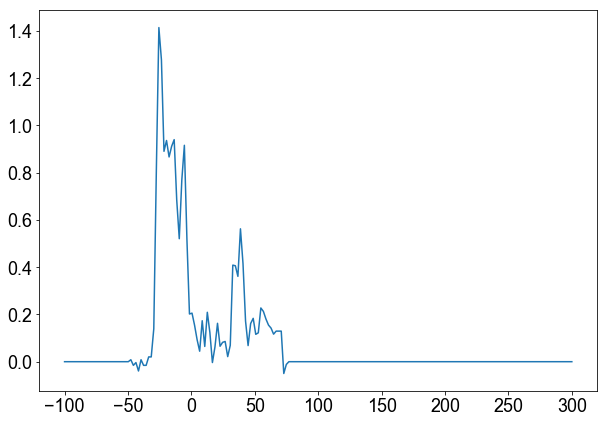

In [42]:
plt.plot(np.linspace(-100, 300, 200), d_nr['s1_pulse'].iloc[0])

### Apply the shift

s1 in [20, 30) selection: 25202 rows removed (10.90% passed)


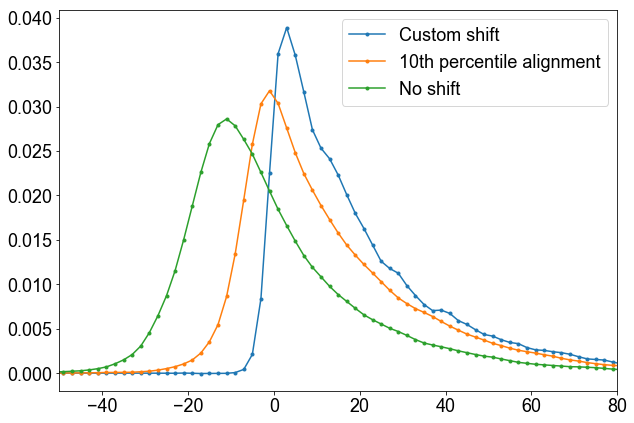

s1 in [190, 200) selection: 28182 rows removed (0.36% passed)
s1 in [190, 200) selection: 21237 rows removed (1.94% passed)
0.499755822445
0.499527714524


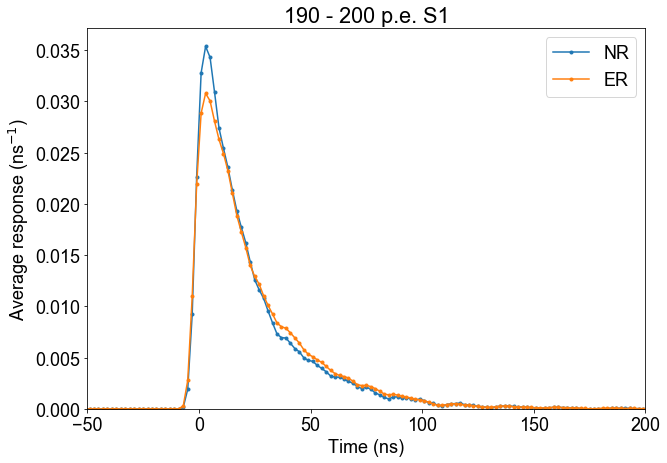

In [120]:
dt = 2
alignment_field = 's1_10p_point'

lower = 190
upper = 200


slice_nr = cuts.range_selection(d_nr, 's1', (lower, upper))
slice_er = cuts.range_selection(d_er, 's1', (lower, upper))

time, amplitude_nr = compute_average_pulse(slice_nr, alignment_field, dt=dt)
plt.plot(time, amplitude_nr, marker='.', label='NR')
print(sum(amplitude_nr))

time, amplitude_er = compute_average_pulse(slice_er, alignment_field, dt=dt)
plt.plot(time, amplitude_er, marker='.', label='ER')
print(sum(amplitude_er))
plt.xlim(-50, 200)
# plt.ylim(0)
# plt.yscale('log')
plt.ylim(1e-5)

plt.ylabel('Average response (ns$^{-1}$)')
plt.xlabel('Time (ns)')
plt.legend()
plt.title('%d - %d p.e. S1' % (lower, upper))
plt.show()


In [47]:
def compute_overlap(pulse, shift, center_time, basic_time, basic_pulse):
    time = np.linspace(-100, 300, 201)
    time = time[:200]
    shift_error = center_time - round(center_time / 2) * 2
    shifted_time = time - shift + shift_error
    pulse = np.array(pulse)/np.sum(pulse)
#    plt.plot(shifted_time, pulse)
    basic_pulse_at_shifted_time = np.interp(shifted_time, basic_time, basic_pulse)
#     plt.plot(shifted_time, basic_pulse_at_shifted_time)
    overlap = np.sum(basic_pulse_at_shifted_time * pulse)
    return overlap

In [48]:
nrness_nr = []
for i in range(len(slice_nr)):
    nrness_nr.append(compute_overlap(slice_nr['s1_pulse'].iloc[i], slice_nr['s1_time_from_midpoint_10p'].iloc[i], 
               slice_nr['s1_center_time'].iloc[i], time, amplitude_nr))
    
nrness_er = []
for i in range(len(slice_er)):
    nrness_er.append(compute_overlap(slice_er['s1_pulse'].iloc[i], slice_er['s1_time_from_midpoint_10p'].iloc[i], 
               slice_er['s1_center_time'].iloc[i], time, amplitude_nr))

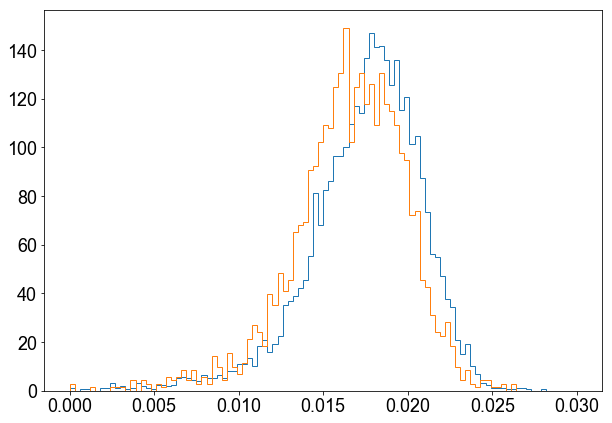

In [49]:
plt.hist(nrness_nr, bins=100, histtype='step', range=(0, 0.03), normed=True)
plt.hist(nrness_er, bins=100, histtype='step', range=(0, 0.03), normed=True)

plt.show()

In [269]:
erness_nr = []
for i in range(len(slice_nr)):
    erness_nr.append(compute_overlap(slice_nr['s1_pulse'].iloc[i], slice_nr['s1_time_from_midpoint_10p'].iloc[i], 
               slice_nr['s1_center_time'].iloc[i], time, amplitude_er))
    
erness_er = []
for i in range(len(slice_er)):
    erness_er.append(compute_overlap(slice_er['s1_pulse'].iloc[i], slice_er['s1_time_from_midpoint_10p'].iloc[i], 
               slice_er['s1_center_time'].iloc[i], time, amplitude_er))

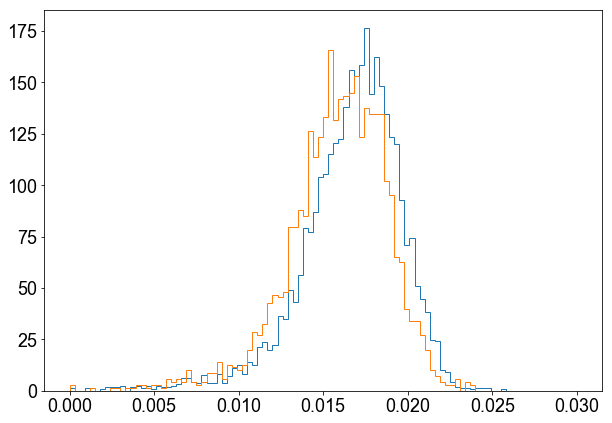

In [270]:
plt.hist(erness_nr, bins=100, histtype='step', range=(0, 0.03), normed=True)
plt.hist(erness_er, bins=100, histtype='step', range=(0, 0.03), normed=True)

plt.show()

In [229]:
slice_nr['s1_time_from_midpoint_10p'].iloc[4]

-16.929516377588342

In [273]:
slice_nr['s1_time_from_midpoint_10p'].iloc[6]

-16.859046052338286

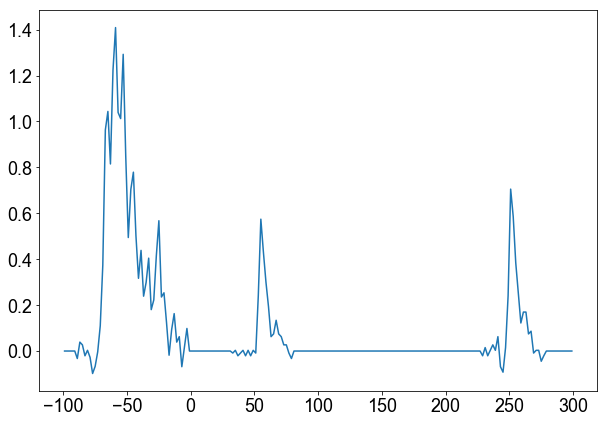

In [271]:
plt.plot(time, slice_nr['s1_pulse'].iloc[6])

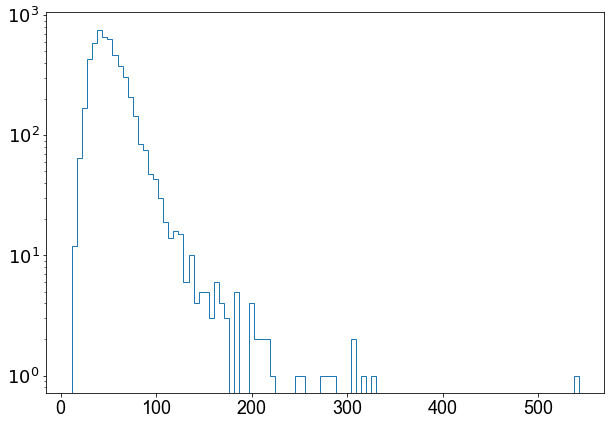

In [279]:
plt.hist(slice_nr['s1_range_80p_area'], bins=100, histtype='step')
plt.yscale('log')
plt.show()

In [280]:
slice_nr_crap = slice_nr[slice_nr['s1_range_80p_area'] > 100]

-12.0415413106


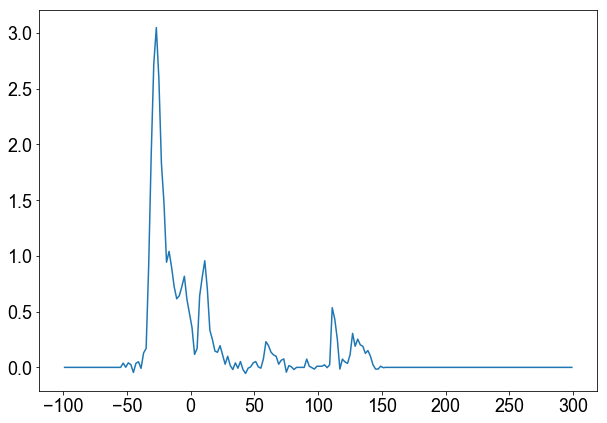

In [290]:
plt.plot(time, slice_nr_crap['s1_pulse'].iloc[6])
print(slice_nr_crap['s1_time_from_midpoint_10p'].iloc[6])

In [294]:
total_area = 0
for bla in slice_nr_crap['s1_pulse'].iloc[6]:
    total_area += bla
print(total_area)
print(slice_nr_crap['s1'].iloc[6])

fractional_area = 0
for i, bla in enumerate(slice_nr_crap['s1_pulse'].iloc[6]):
    fractional_area += bla
    if fractional_area >= 0.1 * total_area:
        print(i)
        print(fractional_area)
        print(time[i])
        break

31.687006898457184
31.6870079041
34
3.267025069333613
-31.0


In [295]:
slice_nr_crap['s1_time_from_midpoint_10p'].iloc[6]

-12.041541310649183

Here is the thing... Time from midpoint is with respect to the 50% area point, which is NOT necessarily the center time...

## Low field

In [14]:
ambe_low = XAMSAnalysis([run_names_ambe_low[0]], processed_data_path, minitree_path)

In [15]:
ambe_low.load(treemakers = ['Basics', 'Fundamentals', S1TimeProperties])

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


Loaded 86240 (86.2 k) events.
Total live time: 900.1 seconds (0.3 hours)


In [7]:
ambe_low.cut_interaction_exists()

Finite s1 selection: 350091 rows removed (64.63% passed)


### z correction

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


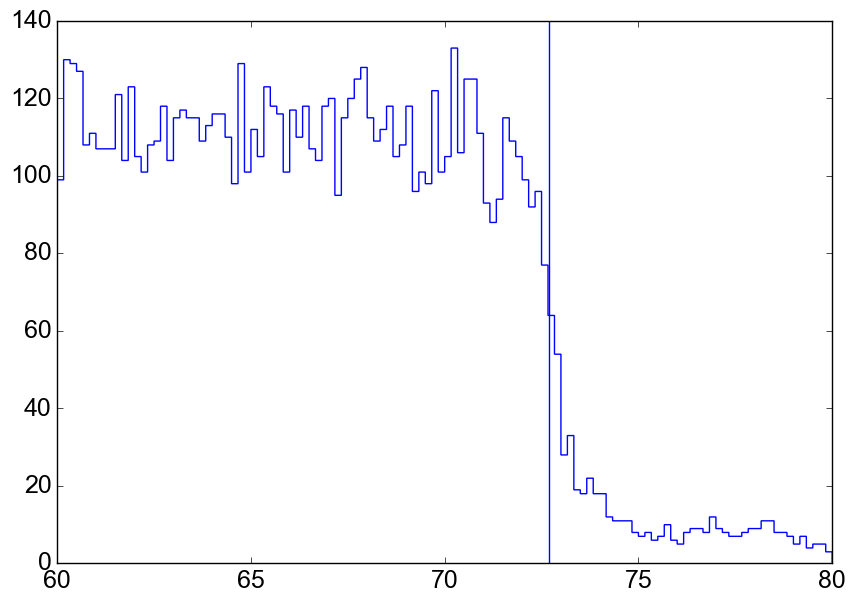

In [17]:
plt.hist(ambe_low.d['drift_time'], bins=120, histtype='step', range=(60, 80))
plt.axvline(72.7)
plt.show()

In [18]:
10 / (72.7 - 1.5)

0.14044943820224717

In [19]:
ambe_low.corr_z(1.5, 1.404)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


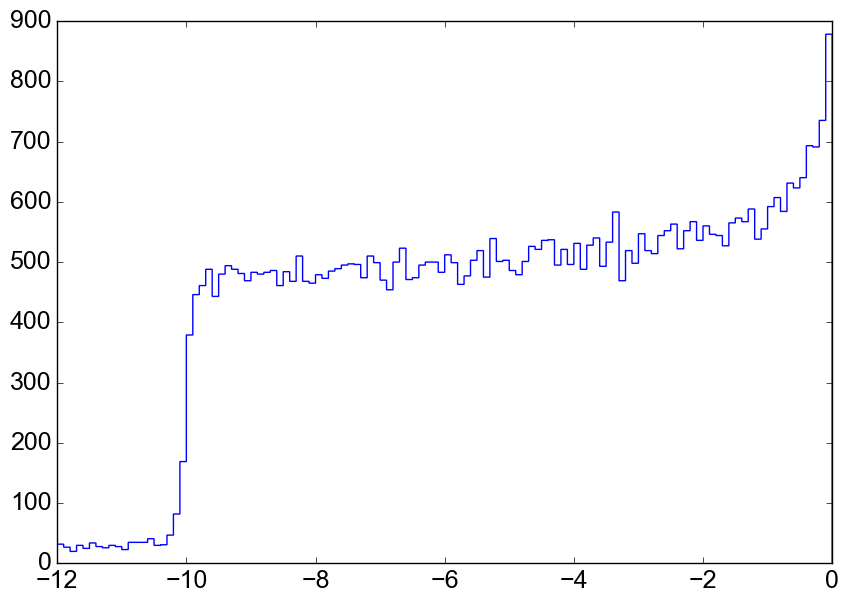

In [20]:
plt.hist(ambe_low.d['z'], bins=120, histtype='step', range=(-12, 0))
plt.show()

ms_since_previous_event above 1.0 selection: 15577 rows removed (81.94% passed)


(1000.0, 100000.0)

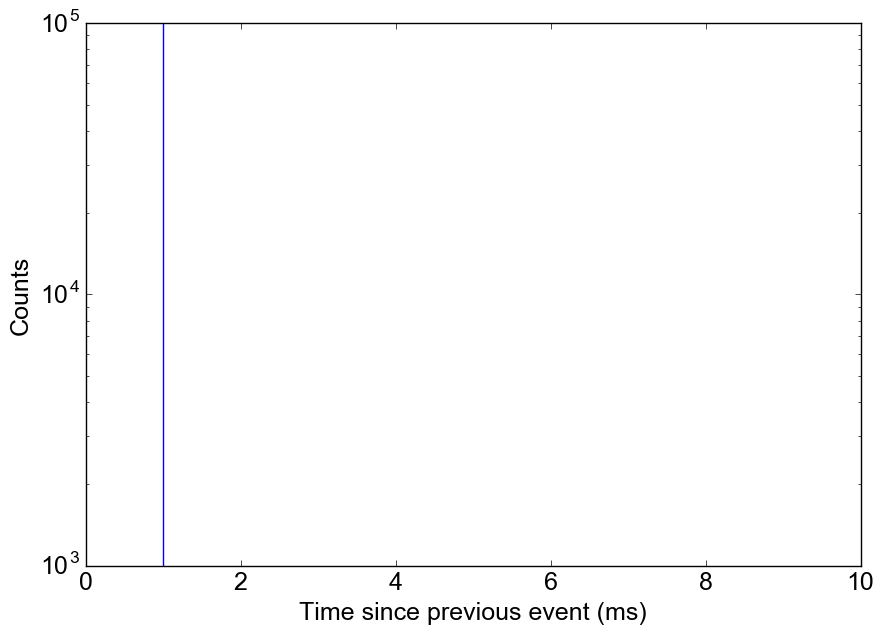

In [27]:
ambe_low.cut_time_since_previous(plot=True, apply=True, bins=100,histtype='step', range=(0, 10))
plt.yscale('log')
plt.ylim(1e3, 1e5)

In [22]:
ambe_low.cut_fiducial_volume()

z in [-9.5, -0.5) selection: 30288 rows removed (57.14% passed)


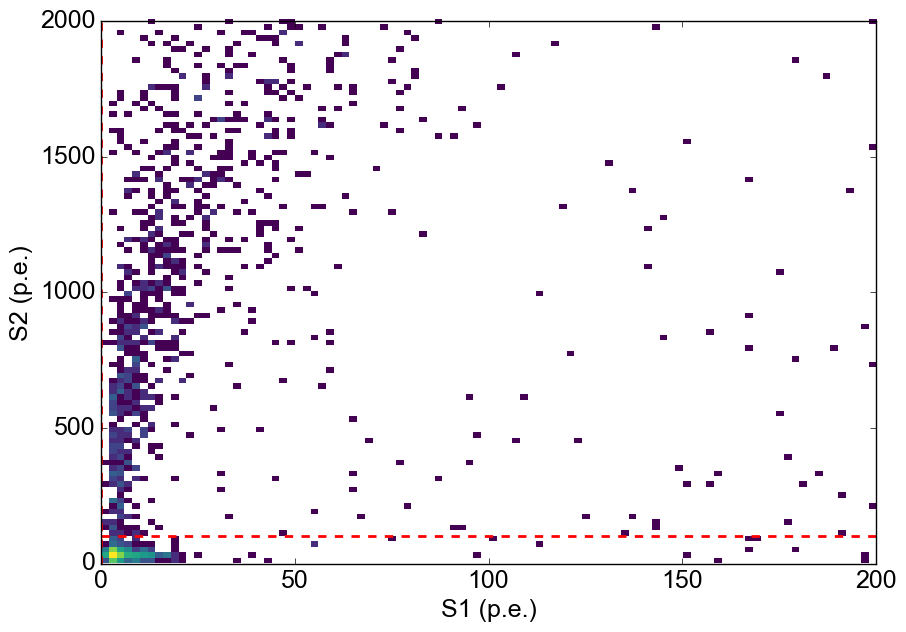

In [23]:
ambe_low.cut_thresholds(s1_threshold=0, s2_threshold=100., plot=True, apply=False, bins=100, norm=LogNorm(),
                        range=((0, 200), (0, 2e3)))

In [25]:

def read_and_cut(run_names, processed_data_path, minitree_path, treemakers = None, field='high', **kwargs):
    x = XAMSAnalysis(run_names, processed_data_path, minitree_path)
    x.load(treemakers=  treemakers, **kwargs)
    if field=='low':
        v_d = 1.404
    elif field=='high':
        v_d = 1.73
    else:
        raise ValueError('Enter a valid field type.')
    x.corr_z(1.5, v_d)
    x.corr_s1_ly_poly(ly_filename='../light_yield/data/cs137_ly_p2_sel2.pickle')
    x.corr_s2_electron_lifetime(pickle_file='../light_yield/data/cs137_electron_lifetime_sel2.pickle', verbose=True)
    x.cut_interaction_exists()
    x.cut_time_since_previous()
    x.cut_fiducial_volume()
    # x.cut_s2_range_50p_area(pickle_file='../light_yield/data/cs137_s2_width.pickle')
    x.cut_thresholds(s1_threshold=0, s2_threshold=100.)
    x.cut_largest_other_s1()
    x.cut_largest_other_s2() 

    print('Events left: %.1f k' % (len(x.d)/1000))
    return x